# __Diabetic Patient Classification__

__NOTE__
<br>
This finalized notebook uses one-hot encoding for all the selected features and standard scaling for scaling. These two approaches were selected as the best fitting for the dataset at hand by trying sevaral methods with each of the models tested here.
> Base Approach - Encoding: Ordinal encoding + One-Hot encoding, Scaling: Standard Scaling
> <br>
> One-Hot Approach - Encoding: One-Hot encoding, Scaling: Standard Scaling
> <br>
> Min-Max Approach - Encoding: Ordinal encoding + One-Hot encoding, Scaling: Min-Max Scaling
> <br>
> Finalized Approch - Encoding: Ordinal encoding + One-Hot encoding, Scaling: Standard Scaling

# Setup

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

import keras_tuner as kt

2024-10-03 19:39:28.728608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 19:39:28.898421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 19:39:28.961852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 19:39:28.984480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 19:39:29.116971: I tensorflow/core/platform/cpu_feature_guar

## Import the Dataset

In [2]:
data = pd.read_csv('diabetic_data.csv')

In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [5]:
data.describe(include='object')

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,5346,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,3,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,Norm,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,2597,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
data.isna().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

There are too many missing values in `max_glu_serum` and `A1Cresult` columns

In [8]:
# Check out colums with non-numeric values
data.dtypes[data.dtypes == object]

race                        object
gender                      object
age                         object
weight                      object
payer_code                  object
medical_specialty           object
diag_1                      object
diag_2                      object
diag_3                      object
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide                     object
citoglipton                 object
insulin             

In [9]:
# Value counts of the target
data['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [10]:
data['readmitted'].value_counts() / data.shape[0] * 100

readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: count, dtype: float64

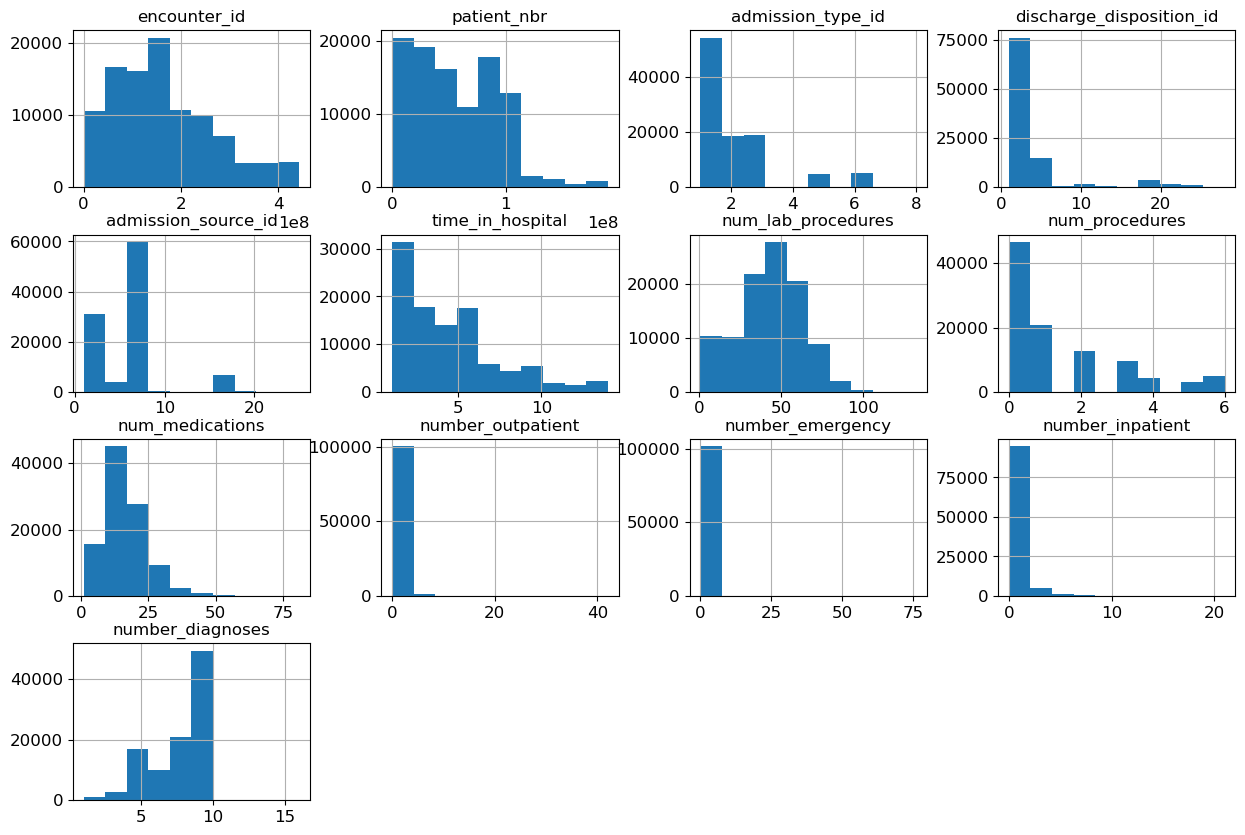

In [11]:
# Distributions of numerical data
ax = data.hist(figsize=(15,10))

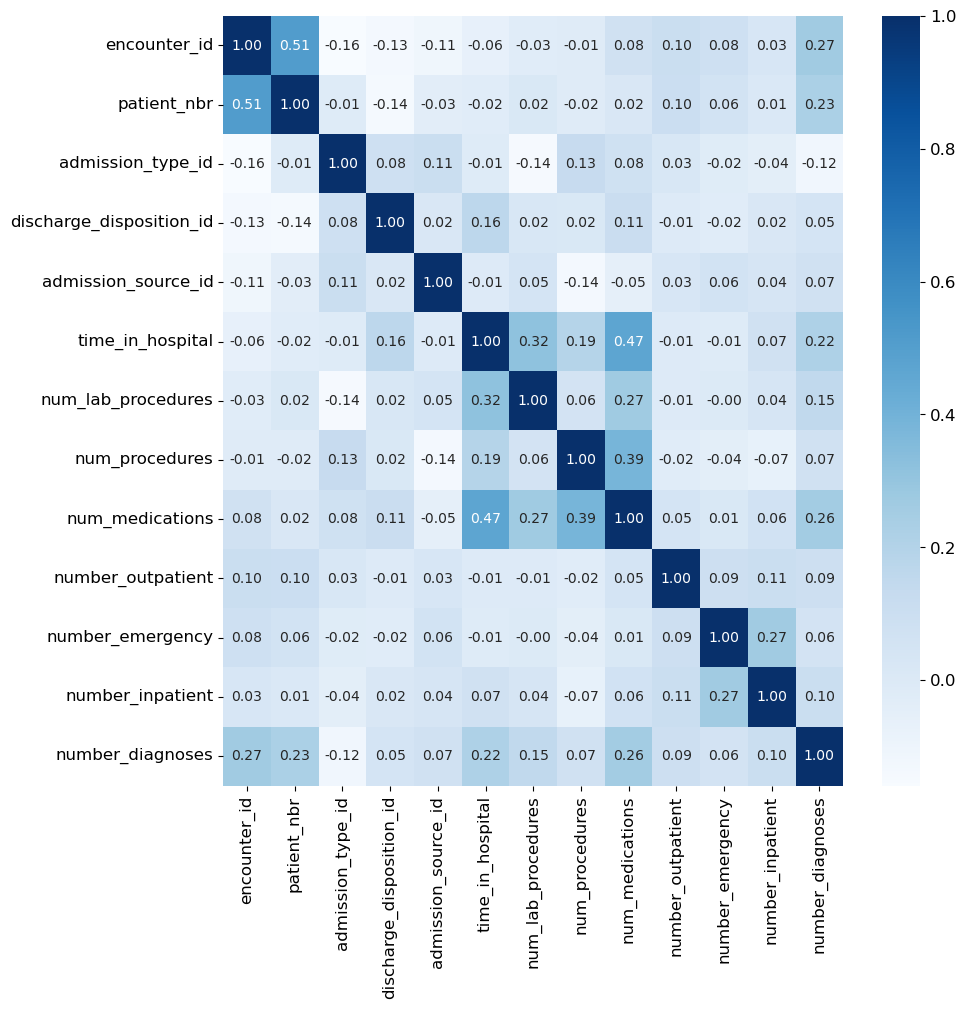

In [12]:
# Correlations bewteen numerical variables
corr_matrix = data[data.dtypes[data.dtypes == 'int64'].index].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.show()

__Insight__
<br>
There are some major correlations between time_in_hospital, num_procedures, num_lab_procedures and num_medications. As well as between num_medications, num_prodedures.

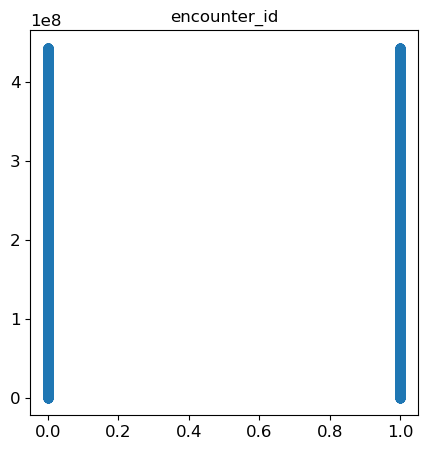

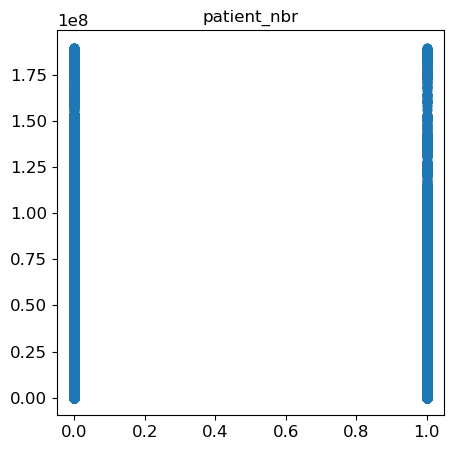

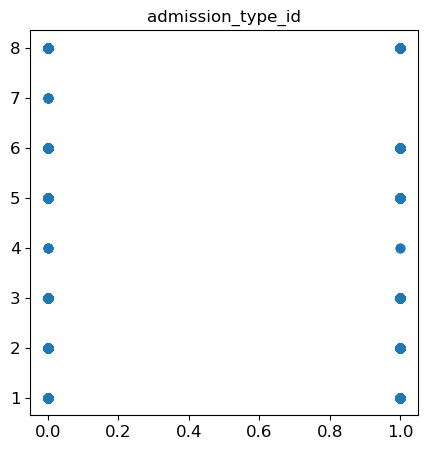

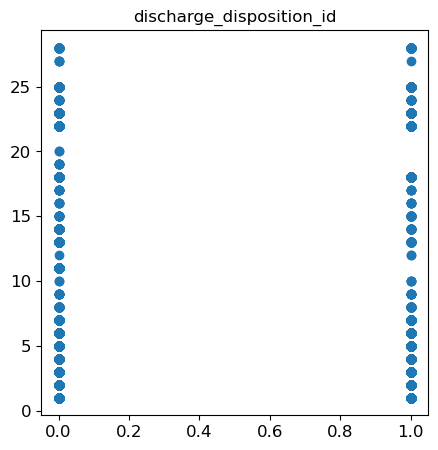

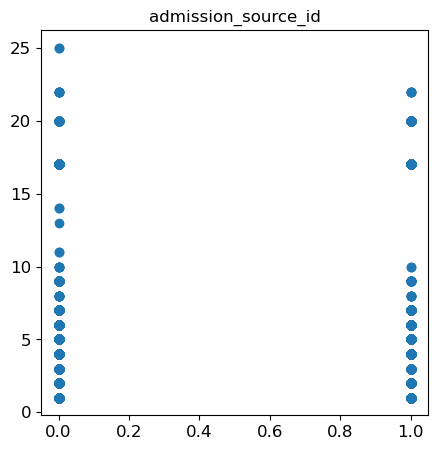

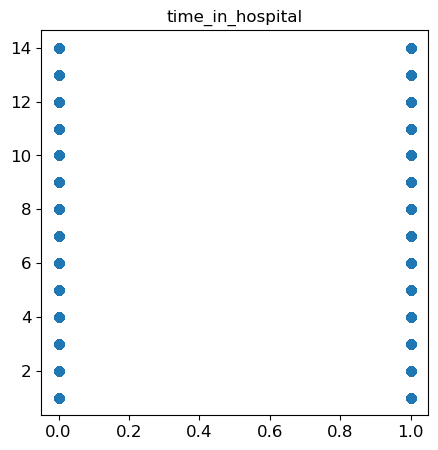

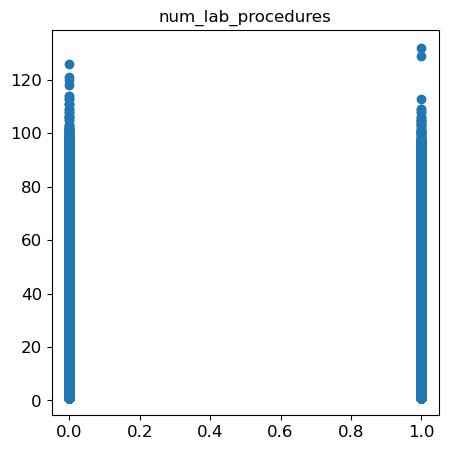

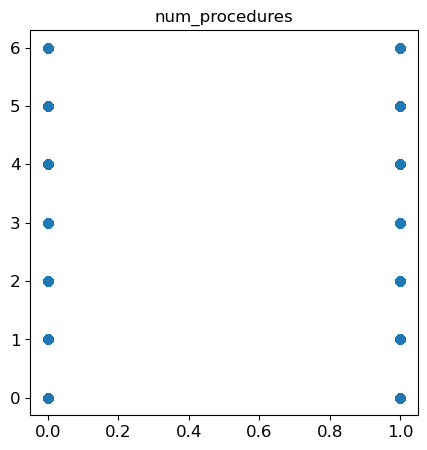

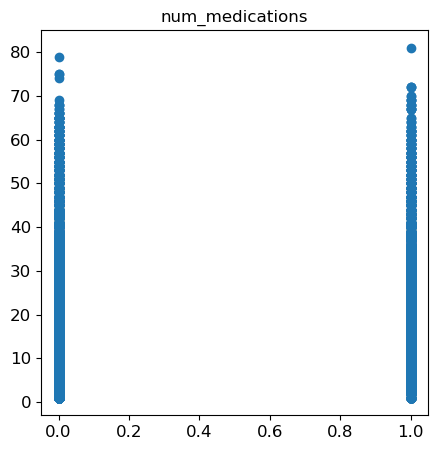

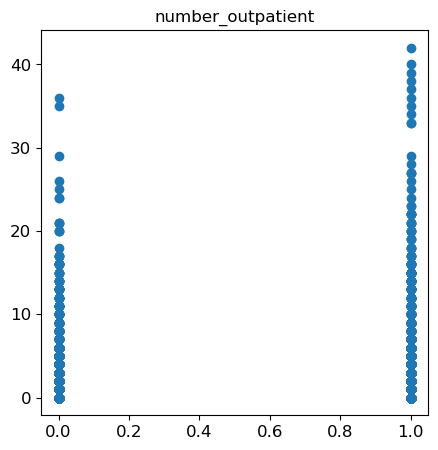

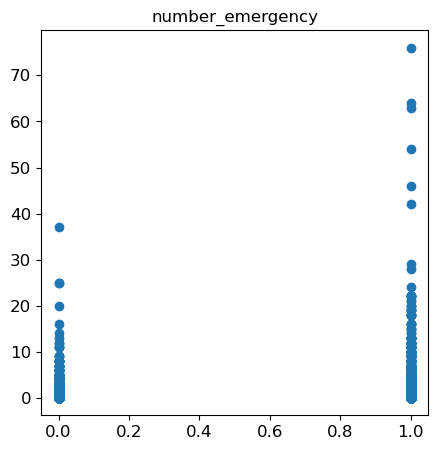

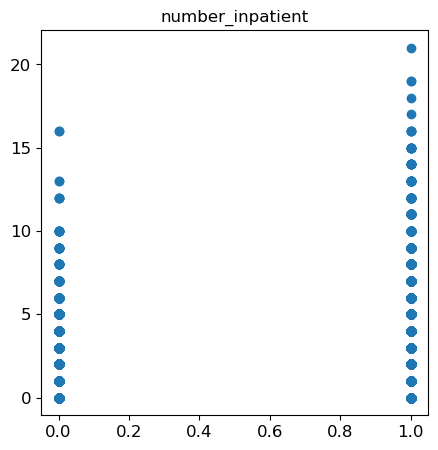

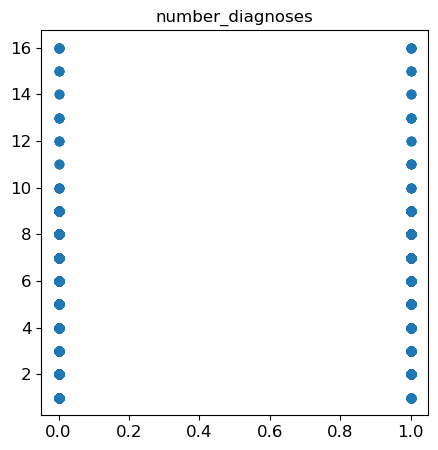

In [13]:
# Correlation with the target and numerical features
df = data.drop(['readmitted'], axis=1)
df_y = pd.DataFrame(data['readmitted'])

df_y['readmitted']=df_y['readmitted'].replace(['NO','>30','<30'],['0','1','1'])
df_y['readmitted']=df_y['readmitted'].astype('int')

df_num_cols = df.dtypes[df.dtypes != 'object'].index
for col in df_num_cols:
    plt.figure(figsize=(5, 5))
    plt.scatter(df_y['readmitted'], data[col])
    plt.title(col)
    plt.show()

In [14]:
object_cols_idx = []
for idx, column in enumerate(data.dtypes.index, start=0):
    if data[column].dtype == object:
        object_cols_idx.append((idx, column))

In [15]:
object_cols_idx

[(2, 'race'),
 (3, 'gender'),
 (4, 'age'),
 (5, 'weight'),
 (10, 'payer_code'),
 (11, 'medical_specialty'),
 (18, 'diag_1'),
 (19, 'diag_2'),
 (20, 'diag_3'),
 (22, 'max_glu_serum'),
 (23, 'A1Cresult'),
 (24, 'metformin'),
 (25, 'repaglinide'),
 (26, 'nateglinide'),
 (27, 'chlorpropamide'),
 (28, 'glimepiride'),
 (29, 'acetohexamide'),
 (30, 'glipizide'),
 (31, 'glyburide'),
 (32, 'tolbutamide'),
 (33, 'pioglitazone'),
 (34, 'rosiglitazone'),
 (35, 'acarbose'),
 (36, 'miglitol'),
 (37, 'troglitazone'),
 (38, 'tolazamide'),
 (39, 'examide'),
 (40, 'citoglipton'),
 (41, 'insulin'),
 (42, 'glyburide-metformin'),
 (43, 'glipizide-metformin'),
 (44, 'glimepiride-pioglitazone'),
 (45, 'metformin-rosiglitazone'),
 (46, 'metformin-pioglitazone'),
 (47, 'change'),
 (48, 'diabetesMed'),
 (49, 'readmitted')]

In [16]:
drug_data = data.iloc[:, 24:47]
drug_data.head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
2,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
4,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,Steady,No,No,No,No,No


In [17]:
# Inspect categories in drug data
drugs_unique_vals = {}
for name in drug_data.columns:
    drugs_unique_vals[name] = [v for v in drug_data[name].unique()]

drugs_unique_vals

{'metformin': ['No', 'Steady', 'Up', 'Down'],
 'repaglinide': ['No', 'Up', 'Steady', 'Down'],
 'nateglinide': ['No', 'Steady', 'Down', 'Up'],
 'chlorpropamide': ['No', 'Steady', 'Down', 'Up'],
 'glimepiride': ['No', 'Steady', 'Down', 'Up'],
 'acetohexamide': ['No', 'Steady'],
 'glipizide': ['No', 'Steady', 'Up', 'Down'],
 'glyburide': ['No', 'Steady', 'Up', 'Down'],
 'tolbutamide': ['No', 'Steady'],
 'pioglitazone': ['No', 'Steady', 'Up', 'Down'],
 'rosiglitazone': ['No', 'Steady', 'Up', 'Down'],
 'acarbose': ['No', 'Steady', 'Up', 'Down'],
 'miglitol': ['No', 'Steady', 'Down', 'Up'],
 'troglitazone': ['No', 'Steady'],
 'tolazamide': ['No', 'Steady', 'Up'],
 'examide': ['No'],
 'citoglipton': ['No'],
 'insulin': ['No', 'Up', 'Steady', 'Down'],
 'glyburide-metformin': ['No', 'Steady', 'Down', 'Up'],
 'glipizide-metformin': ['No', 'Steady'],
 'glimepiride-pioglitazone': ['No', 'Steady'],
 'metformin-rosiglitazone': ['No', 'Steady'],
 'metformin-pioglitazone': ['No', 'Steady']}

__Insight:__
<br>
There are no unrecorded values in drug columns

In [18]:
# Inspect other categorical features
other_cat_cols = ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 
                  'diag_3', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted']
                  
other_cat_data = data[other_cat_cols]
other_cat_data

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,?,Pediatrics-Endocrinology,250.83,?,?,NaN,NaN,No,No,NO
1,Caucasian,Female,[10-20),?,?,?,276,250.01,255,NaN,NaN,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),?,?,?,648,250,V27,NaN,NaN,No,Yes,NO
3,Caucasian,Male,[30-40),?,?,?,8,250.43,403,NaN,NaN,Ch,Yes,NO
4,Caucasian,Male,[40-50),?,?,?,197,157,250,NaN,NaN,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),?,MC,?,250.13,291,458,NaN,>8,Ch,Yes,>30
101762,AfricanAmerican,Female,[80-90),?,MC,?,560,276,787,NaN,NaN,No,Yes,NO
101763,Caucasian,Male,[70-80),?,MC,?,38,590,296,NaN,NaN,Ch,Yes,NO
101764,Caucasian,Female,[80-90),?,MC,Surgery-General,996,285,998,NaN,NaN,Ch,Yes,NO


In [19]:
# Inspect categories in drug data
other_unique_vals = {}
for name in other_cat_data.columns:
    if len(other_cat_data[name].unique()) < 25:
        other_unique_vals[name] = [v for v in other_cat_data[name].unique()]

other_unique_vals

{'race': ['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'],
 'gender': ['Female', 'Male', 'Unknown/Invalid'],
 'age': ['[0-10)',
  '[10-20)',
  '[20-30)',
  '[30-40)',
  '[40-50)',
  '[50-60)',
  '[60-70)',
  '[70-80)',
  '[80-90)',
  '[90-100)'],
 'weight': ['?',
  '[75-100)',
  '[50-75)',
  '[0-25)',
  '[100-125)',
  '[25-50)',
  '[125-150)',
  '[175-200)',
  '[150-175)',
  '>200'],
 'payer_code': ['?',
  'MC',
  'MD',
  'HM',
  'UN',
  'BC',
  'SP',
  'CP',
  'SI',
  'DM',
  'CM',
  'CH',
  'PO',
  'WC',
  'OT',
  'OG',
  'MP',
  'FR'],
 'max_glu_serum': [nan, '>300', 'Norm', '>200'],
 'A1Cresult': [nan, '>7', '>8', 'Norm'],
 'change': ['No', 'Ch'],
 'diabetesMed': ['No', 'Yes'],
 'readmitted': ['NO', '>30', '<30']}

The `diag_1`, `diag_2`, and `diag_3` columns are not included in the unique element list since they have more than 700 unique values.
<br>
Also, there seem to be a `?` value in some columns that represent unrecorded values

In [20]:
# Let's see what columns got the ? value
# Inspect categories in drug data
for name in other_cat_data.columns:
    if '?' in other_cat_data[name].unique():
        print(f"{name} {len(other_cat_data[other_cat_data[name] == '?'])}")

race 2273
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423


In [21]:
# Replace '?' values with nan values
data_rep_ques = data.replace('?', np.nan)
# Replace Unknown/Invalid with nan values
data_rep_ques = data_rep_ques.replace('Unknown/Invalid', np.nan)

In [22]:
# Let's see how many missing values in total we have got and their ratios
# Function to get all the missing values
def all_missing_values(df):
    missing_values = {}
    for col in df.columns:
        if df[col].isna().sum() > 0:
            missing_values[col] = {'count': df[col].isna().sum(), 
                                   'percentage': round((df[col].isna().sum() / df.shape[0]) * 100, 2)}
    return missing_values

In [23]:
pd.DataFrame(all_missing_values(data_rep_ques))

,race,gender,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult
count,2273.00,3.0,98569.00,40256.00,49949.00,21.00,358.00,1423.0,96420.00,84748.00
percentage,2.23,0.0,96.86,39.56,49.08,0.02,0.35,1.4,94.75,83.28


# Handling Missing Values

* Remove all the columns that has >80% missing values except for max_glu_serum and A1Cresult, since the missing values in these features represent patients who did not undergo these test, which may rsult in them being readmitted.
* Some studies indicate that people of certain races often get diagnosed with diabetes. Therefore we will impute the missing race values.
* Drop the samples with missing gender values as there are only 3 of them.
* There are ≈49% values missing in the `medical_speciality` columns which represents medical speciality of the admitting physician. This is a variable that cannot be imputed as it will misdirect the model. The admitting doctor conducts the initial diagnosis of a patient, therefore it is important for the purpose of this project, but we already have the initial diagnosis results, therfore we will drop this column.
* The `payer_code` represent the entitiy that payed the medical fees of the patient. This column has ≈39% of the values missing. The missing values cannto be imputed because doing so will misdirect the model and there are no viable resources to identify what these values actually mean. On the assumption that a patient will readmit purely based on the medical condition and not on financial situation we will remove this column.
* The `diag_1`, `diag_2`, and `diag_3` columns' missing values cannot be imputed, but there is only a small number (<1.5%). Therefore the corresponding rows will be removed.

### `Race`

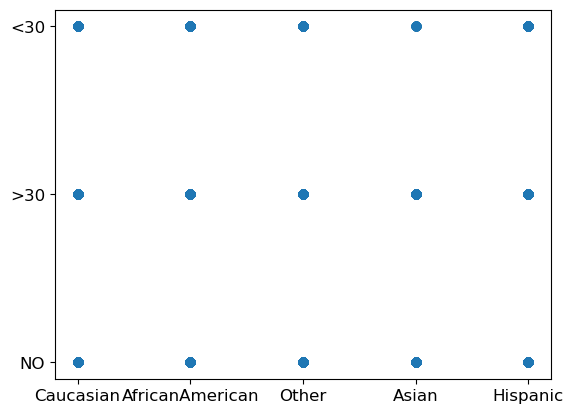

In [24]:
# Relationship between race and readmittence
no_mis_race_df = data_rep_ques[(data_rep_ques['race'].isna()).apply(lambda x: not x)]

plt.scatter(no_mis_race_df['race'], no_mis_race_df['readmitted'])
plt.show()

In [25]:
no_mis_race_vc = no_mis_race_df.groupby('race')['readmitted'].value_counts()
no_mis_race_c = no_mis_race_df.groupby('race')['readmitted'].count()
no_mis_race_vc / no_mis_race_c * 100

race             readmitted
AfricanAmerican  NO            54.247788
                 >30           34.534097
                 <30           11.218116
Asian            NO            64.742590
                 >30           25.117005
                 <30           10.140406
Caucasian        NO            53.066400
                 >30           35.643044
                 <30           11.290556
Hispanic         NO            58.075601
                 >30           31.516937
                 <30           10.407462
Other            NO            60.756972
                 >30           29.614874
                 <30            9.628154
dtype: float64

In [26]:
data_rep_ques['race'].value_counts()

race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

In [27]:
# imputer = SimpleImputer(strategy='most_frequent')
# race_imputed = imputer.fit_transform(pd.DataFrame(data_rep_ques['race']))
# #data_race_imp['race'] = race_imputed.ravel()

In [28]:
# Impute the race
data_race_imp = data_rep_ques.copy()
data_race_imp['race'] = data_race_imp['race'].fillna(method='ffill')
data_race_imp['race'].value_counts()

/tmp/ipykernel_599/2265951200.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_race_imp['race'] = data_race_imp['race'].fillna(method='ffill')


race
Caucasian          77840
AfricanAmerican    19622
Hispanic            2094
Other               1542
Asian                668
Name: count, dtype: int64

### `payer_code`

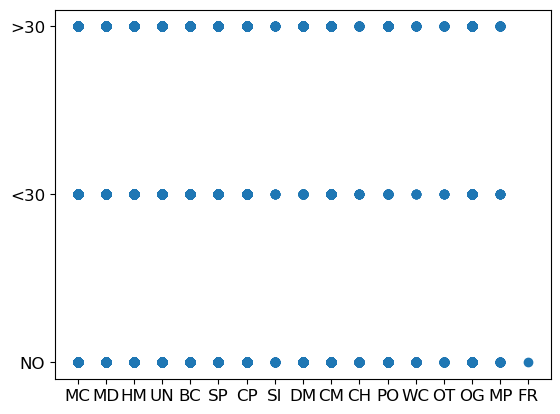

In [29]:
# Relationship between payer_code and readmittence
no_mis_payer_code_df = data_race_imp[(data_race_imp['payer_code'].isna()).apply(lambda x: not x)]

plt.scatter(no_mis_payer_code_df['payer_code'], no_mis_payer_code_df['readmitted'])
plt.show()

In [30]:
payer_code_vc = no_mis_payer_code_df.groupby('payer_code')['readmitted'].value_counts()

payer_code_c = no_mis_payer_code_df.groupby('payer_code')['readmitted'].count()

payer_code_vc / payer_code_c * 100

payer_code  readmitted
BC          NO             62.900107
            >30            27.948443
            <30             9.151450
CH          NO             68.493151
            >30            22.602740
            <30             8.904110
CM          NO             55.653072
            >30            34.124935
            <30            10.221993
CP          NO             60.718516
            >30            30.833004
            <30             8.448480
DM          NO             48.269581
            >30            40.072860
            <30            11.657559
FR          NO            100.000000
HM          NO             52.757412
            >30            36.978004
            <30            10.264584
MC          NO             51.317858
            >30            36.937020
            <30            11.745122
MD          NO             52.576444
            >30            35.645527
            <30            11.778029
MP          >30            49.367089
            NO 

* There does not seem to be any relationship bewteen the `payer_code` and `readmitted`. Therefore, let's drop it.

### `max_glu_serum`

In [31]:
# Fill the missing values with none to indicate that the patient has not taken the test
data_fill_mgs = data_race_imp.copy()

data_fill_mgs['max_glu_serum'] = data_fill_mgs['max_glu_serum'].fillna('none')
data_fill_mgs['max_glu_serum'].value_counts()

max_glu_serum
none    96420
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64

### `A1Cresult`

In [32]:
# Fill the missing values with none to indicate that the patient has not taken the test
data_fill_a1c = data_fill_mgs.copy()

data_fill_a1c['A1Cresult'] = data_fill_a1c['A1Cresult'].fillna('none')
data_fill_a1c['A1Cresult'].value_counts()

A1Cresult
none    84748
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64

### Rest of the features

In [33]:
data_dropped_cols = data_fill_a1c.copy()

# Remove the selected columns
data_dropped_cols = data_dropped_cols.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

In [34]:
# Remove rows conating missing values for `diag_1`, `diag_2`, and `diag_3`
data_dropped_rows = data_dropped_cols.dropna(axis=0, subset=['gender', 'diag_1', 'diag_2', 'diag_3'])

In [35]:
# Check
all_missing_values(data_dropped_rows)

{}

In [36]:
# Checkpoint
data_no_mv = data_dropped_rows.copy()
data_no_mv.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,>30


## Duplicated values

In [37]:
# Function to check for duplicated values in numerical columns
def get_duplicates(df):
    n_cols = list(df.dtypes[df.dtypes == 'int64'].index)
    duplicates = {}
    for idx, col in enumerate(n_cols):
        duplicates[col] = df[col].duplicated().sum()
    return duplicates

get_duplicates(data_no_mv)

{'encounter_id': 0,
 'patient_nbr': 29828,
 'admission_type_id': 100233,
 'discharge_disposition_id': 100215,
 'admission_source_id': 100224,
 'time_in_hospital': 100227,
 'num_lab_procedures': 100123,
 'num_procedures': 100234,
 'num_medications': 100166,
 'number_outpatient': 100202,
 'number_emergency': 100208,
 'number_inpatient': 100221,
 'number_diagnoses': 100227}

In [38]:
# Check duplicated values in the patient_nbr
data_no_mv[data_no_mv['patient_nbr'].duplicated()]

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
79,1070256,23043240,Caucasian,Female,[50-60),2,1,4,3,41,...,No,Steady,No,No,No,No,No,No,Yes,>30
81,1077924,21820806,AfricanAmerican,Male,[50-60),1,6,7,3,52,...,No,No,No,No,No,No,No,No,No,NO
143,2309376,41606064,Caucasian,Male,[20-30),2,1,2,2,35,...,No,Steady,No,No,No,No,No,No,Yes,>30
175,2552952,86240259,Caucasian,Female,[70-80),1,3,7,11,44,...,No,Up,No,No,No,No,No,Ch,Yes,>30
307,3174918,5332491,Other,Female,[60-70),6,25,7,5,58,...,No,Steady,No,No,No,No,No,No,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,443847176,50375628,AfricanAmerican,Female,[60-70),1,1,7,6,45,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101761,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,...,No,Down,No,No,No,No,No,Ch,Yes,NO


In [39]:
# Check a single duplicated record
data_no_mv[data_no_mv['patient_nbr'] == 50375628]

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
46441,143247264,50375628,AfricanAmerican,Female,[60-70),1,1,7,2,37,...,No,No,No,No,No,No,No,No,No,>30
61710,172123572,50375628,AfricanAmerican,Female,[60-70),1,1,7,2,18,...,No,Down,No,No,No,No,No,Ch,Yes,>30
64762,180190776,50375628,AfricanAmerican,Female,[60-70),1,1,7,2,41,...,No,Down,No,No,No,No,No,Ch,Yes,>30
78512,239936226,50375628,AfricanAmerican,Female,[60-70),1,1,7,10,60,...,No,Up,No,No,No,No,No,Ch,Yes,>30
81570,252908004,50375628,AfricanAmerican,Female,[60-70),1,1,7,8,42,...,No,Up,No,No,No,No,No,Ch,Yes,>30
95238,359084438,50375628,AfricanAmerican,Female,[60-70),1,1,7,8,59,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
101760,443847176,50375628,AfricanAmerican,Female,[60-70),1,1,7,6,45,...,No,Down,No,No,No,No,No,Ch,Yes,>30


__Insight:__
<br>
There are multiple recores for the same person, these are seperate admissions for the same patient at different points in time. We will refrain from removing these duplicates because most patients, specially older ones, have most probably been taking medications for diabetes for some time. It is unrealistic to expect all the patient records to be of patients that got diagnosed with diabetes for the first time. also removing duplicates will result in losing a large number of valueble data.

# Feature Engineering

In [40]:
data_no_mv.dtypes[data_no_mv.dtypes == 'int64']

encounter_id                int64
patient_nbr                 int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
dtype: object

In [41]:
data_no_mv.dtypes[data_no_mv.dtypes == 'object']

race                        object
gender                      object
age                         object
diag_1                      object
diag_2                      object
diag_3                      object
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide                     object
citoglipton                 object
insulin                     object
glyburide-metformin         object
glipizide-metformin         object
glimepiride-pioglita

Since `encounter_id` and `patient_nbr` does not affect a patients readmission, we'll drop them too.

In [42]:
# Drop encounter id and patient nbr
data_drp_nbr = data_no_mv.drop(['encounter_id', 'patient_nbr'], axis=1)

## `admission_type_id`

In [43]:
# 1: Emergency
# 2: Urgent
# 3: Elective
# 4: Newborn
# 5: Not Available
# 6: NULL (not mapped)
# 7: Trauma Center
# 8: Not Mapped

In [44]:
data_map_ids = data_drp_nbr.copy()

In [45]:
# 5: Not available; 6,8: Not mapped
(data_map_ids['admission_type_id'].value_counts() / data_map_ids.shape[0]) * 100

admission_type_id
1    53.102024
3    18.499416
2    18.159236
6     5.186501
5     4.707655
8     0.314243
7     0.020950
4     0.009976
Name: count, dtype: float64

In [46]:
unique_vals = data_map_ids['admission_type_id'].unique()
unique_vals.sort()
unique_vals

array([1, 2, 3, 4, 5, 6, 7, 8])

Map emergency and urgent admissions seperately and other non urgent ones like elective into 'other' based on frequency and urgency of the admission

In [47]:
admission_type_id_map = {
    1: 'emergency',
    2: 'urgent',
    3: 'other',
    4: 'other',
    5: 'other',
    6: 'other',
    7: 'other',
    8: 'other'
}

data_map_ids['admission_type_id'] = data_map_ids['admission_type_id'].map(admission_type_id_map)
data_map_ids['admission_type_id'].value_counts()

admission_type_id
emergency    53230
other        28808
urgent       18203
Name: count, dtype: int64

## `discharge_disposition_id`

In [48]:
    # 1: 'Discharged to home',
    # 2: 'Discharged/transferred to another short-term hospital',
    # 3: 'Discharged/transferred to a skilled nursing facility',
    # 4: 'Discharged/transferred to Intermediate Care Facility (ICF)',
    # 5: 'Discharged/transferred to another type of institution',
    # 6: 'Discharged/transferred to home with home health service',
    # 7: 'Left against medical advice',
    # 8: 'Discharged/transferred to home under care of home IV provider',
    # 9: 'Admitted as an inpatient to this hospital',
    # 10: 'Discharged/transferred to psychiatric hospital',
    # 11: 'Discharged/transferred to another rehabilitation facility',
    # 12: 'Discharged/transferred to long-term care hospital',
    # 13: 'Expired',
    # 14: 'Still patient'
    # 15: 'Hospice, home care',
    # 16: 'Hospice, medical facility',
    # 17: 'Discharged/transferred to a swing bed',
    # 18: 'Expired at home',
    # 19: 'Expired in a medical facility',
    # 20: 'Expired, place unknown',
    # 22: 'Expired (Medicare Part A)',
    # 23: 'Discharged/transferred to an unknown destination',
    # 24: 'Discharged/transferred to federal healthcare facility',
    # 25: 'Expired (Medicaid patient)',
    # 26: 'Discharged/transferred to Intermediate Care Facility (not under Medicare)',
    # 27: 'Expired (hospice)',
    # 28: 'Discharged/transferred to Critical Access Hospital (CAH)',

In [49]:
(data_map_ids['discharge_disposition_id'].value_counts() / data_map_ids.shape[0]) * 100

discharge_disposition_id
1     58.861145
3     13.863589
6     12.799154
18     3.633244
2      2.109915
22     1.976237
11     1.636057
5      1.164194
25     0.953702
4      0.803065
7      0.602548
23     0.405024
13     0.397043
14     0.370108
28     0.137668
8      0.106743
15     0.062849
24     0.047885
9      0.020950
17     0.013966
16     0.010974
19     0.007981
10     0.005986
27     0.004988
12     0.002993
20     0.001995
Name: count, dtype: float64

In [50]:
unique_vals = data_map_ids['discharge_disposition_id'].unique()
unique_vals.sort()
unique_vals

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 23, 24, 25, 27, 28])

__Actions__
<br>
* Remove records with discharge_disposition_id values corresponding to expired (13, 18, 19, 20, 22, 25, 27) since desceased patients are not relevant for the readmission prediction.
* Divide the values to: home, hospice, facility and other based on discharged location and condition

In [51]:
# Remove expired records
remove_expired = {
    13: np.nan,
    18: np.nan,
    19: np.nan,
    20: np.nan,
    22: np.nan,
    25: np.nan,
    27: np.nan,
}

data_map_dis = data_map_ids.copy()
data_map_dis['discharge_disposition_id'] = data_map_dis['discharge_disposition_id'].replace(remove_expired)
print(f'Expired records: {data_map_dis['discharge_disposition_id'].isna().sum()}')
data_map_dis = data_map_dis.dropna(subset=['discharge_disposition_id'], axis=0)

print(f'New record count: {data_map_dis.shape[0]}')

Expired records: 6992
New record count: 93249


In [52]:
discharge_disposition_id_map = {
    1: 'home',
    2: 'facility',
    3: 'facility',
    4: 'facility',
    5: 'facility',
    6: 'home',
    7: 'other',
    8: 'home',
    9: 'other',
    10: 'facility',
    11: 'facility',
    12: 'facility',
    14: 'other',
    15: 'hospice',
    16: 'hospice',
    17: 'facility',
    23: 'other',
    24: 'facility',
    28: 'facility',
}

data_map_dis['discharge_disposition_id'] = data_map_dis['discharge_disposition_id'].map(discharge_disposition_id_map)
data_map_dis['discharge_disposition_id'].value_counts()

discharge_disposition_id
home        71940
facility    19833
other        1402
hospice        74
Name: count, dtype: int64

## `admission_source_id`

In [53]:
# admission_source_id	Description
# 1	Physician Referral
# 2	Clinic Referral
# 3	HMO Referral
# 4	Transfer from a hospital (Different facility)
# 5	Transfer from a Skilled Nursing Facility (SNF)
# 6	Transfer from another health care facility
# 7	Emergency Room
# 8	Court/Law Enforcement
# 9	Not Available
# 10	Transfer from a critical access hospital
# 11	Transfer from another health care facility
# 12	Transfer from a hospital-based Medicare-approved swing bed
# 13	Transfer from an intermediate care facility (ICF)
# 14	Transfer from a custodial care facility
# 15	Transfer from a psychiatric hospital
# 16	Transfer from a rehabilitation facility
# 17	Transfer from a long-term care hospital
# 18	Transfer from another inpatient rehabilitation facility
# 19	Transfer from an ambulatory surgery center
# 20	Transfer from hospice
# 21	Transfer from a federal health care facility
# 22	Transfer from another facility not defined elsewhere
# 23	Transfer from a nursing facility with Medicare certification but not classified as a skilled nursing facility (SNF)
# 24	Transfer from a hospice facility
# 25	Unknown or not mapped

In [54]:
(data_map_dis['admission_source_id'].value_counts() / data_map_dis.shape[0]) * 100

admission_source_id
7     56.995785
1     29.009426
17     6.681037
4      2.808609
6      2.244528
2      1.030574
5      0.790357
20     0.172656
9      0.116891
3      0.105095
8      0.016086
22     0.012869
10     0.008579
14     0.002145
11     0.002145
25     0.002145
13     0.001072
Name: count, dtype: float64

In [55]:
unique_vals = data_map_dis['admission_source_id'].unique()
unique_vals.sort()
unique_vals

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 17, 20, 22, 25])

In [56]:
admission_source_id_map = {
    1: 'referral',
    2: 'referral',
    3: 'referral',
    4: 'transfer',
    5: 'transfer',
    6: 'transfer',
    7: 'emergency',
    8: 'other',
    9: 'other',
    10: 'transfer',
    11: 'transfer',
    13: 'transfer',
    14: 'transfer',
    17: 'transfer',
    20: 'transfer',
    22: 'transfer',
    25: 'other'
}

data_map_dis['admission_source_id'] = data_map_dis['admission_source_id'].map(admission_source_id_map)
data_map_dis['admission_source_id'].value_counts()

admission_source_id
emergency    53148
referral     28110
transfer     11865
other          126
Name: count, dtype: int64

In [57]:
data_map_dis.head(3)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),emergency,home,emergency,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),emergency,home,emergency,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),emergency,home,emergency,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO


## `diag_1`, `diag_2`, `diag_3`

Map diagnosis into 'yes' or 'no' depending on if the the patient's condition was diagnosed as diabetes or not

In [58]:
data_map_diag = data_map_dis.copy()

# Function to assign if diagnois is diabetes or not
def map_diag(x):
    diabetes = [
        '250.7', '250.6', '250.4', '250.32', '250.13', '250.03', '250.8', '250.42',
        '250.41', '250.02', '250.22', '250.82', '250.83', '250.33', '250.12',
        '250.01', '250.11', '250.3', '250.43', '250.2', '250.9', '250.21', '250.93',
        '250.91', '250.81', '250.53', '250.92', '250.51', '250.31', '250.01', '250'
    ]

    val = 'No'
    if x in diabetes:
        val = 'Yes'
    return val


for col in ['diag_1', 'diag_2', 'diag_3']:
    data_map_diag[col] = data_map_diag[col].apply(map_diag)

In [59]:
data_map_diag[['diag_1', 'diag_2', 'diag_3']]

,diag_1,diag_2,diag_3
1,No,Yes,No
2,No,Yes,No
3,No,Yes,No
4,No,No,Yes
5,No,No,Yes
...,...,...,...
101761,Yes,No,No
101762,No,No,No
101763,No,No,No
101764,No,No,No


In [60]:
print(data_map_diag['diag_1'].value_counts())
print(data_map_diag['diag_2'].value_counts())
print(data_map_diag['diag_3'].value_counts())

diag_1
No     85933
Yes     7316
Name: count, dtype: int64
diag_2
No     82160
Yes    11089
Name: count, dtype: int64
diag_3
No     77646
Yes    15603
Name: count, dtype: int64


## drug columns

In [61]:
data_map_drugs = data_map_diag.copy()

# Function to get count of each increased, decreased and steady doses
# of all the drugs for each patient
def get_dosage_changes(row, val, start_col_idx, end_col_idx):
    val_count = 0
    for col in row.index[start_col_idx:end_col_idx]:
        if row[col] == val:
            val_count += 1
    return val_count

# Function to map drug column values
# def map_drugs(x):
#     pres = 'Yes'
#     if x == 'No':
#         pres = 'No'
#     return pres

In [62]:
# Inspect categories in drug data
drugs_unique_vals = {}
for name in drug_data.columns:
    drugs_unique_vals[name] = [v for v in data_map_drugs[name].unique()]
    
drugs_unique_vals

{'metformin': ['No', 'Steady', 'Up', 'Down'],
 'repaglinide': ['No', 'Up', 'Steady', 'Down'],
 'nateglinide': ['No', 'Steady', 'Down', 'Up'],
 'chlorpropamide': ['No', 'Steady', 'Down', 'Up'],
 'glimepiride': ['No', 'Steady', 'Up', 'Down'],
 'acetohexamide': ['No'],
 'glipizide': ['No', 'Steady', 'Up', 'Down'],
 'glyburide': ['No', 'Steady', 'Up', 'Down'],
 'tolbutamide': ['No', 'Steady'],
 'pioglitazone': ['No', 'Up', 'Steady', 'Down'],
 'rosiglitazone': ['No', 'Steady', 'Up', 'Down'],
 'acarbose': ['No', 'Steady', 'Up', 'Down'],
 'miglitol': ['No', 'Steady', 'Down', 'Up'],
 'troglitazone': ['No', 'Steady'],
 'tolazamide': ['No', 'Steady'],
 'examide': ['No'],
 'citoglipton': ['No'],
 'insulin': ['Up', 'No', 'Steady', 'Down'],
 'glyburide-metformin': ['No', 'Steady', 'Down', 'Up'],
 'glipizide-metformin': ['No', 'Steady'],
 'glimepiride-pioglitazone': ['No', 'Steady'],
 'metformin-rosiglitazone': ['No', 'Steady'],
 'metformin-pioglitazone': ['No', 'Steady']}

In [63]:
# Inspect the value counts in each drug column
for name in data_map_drugs.iloc[:, 19:42].columns:
    print(round(data_map_drugs[name].value_counts() / data_map_drugs.shape[0] * 100, 3), end='\n\n')

metformin
No        80.389
Steady    18.039
Up         1.017
Down       0.556
Name: count, dtype: float64

repaglinide
No        98.446
Steady     1.402
Up         0.109
Down       0.043
Name: count, dtype: float64

nateglinide
No        99.270
Steady     0.694
Up         0.025
Down       0.012
Name: count, dtype: float64

chlorpropamide
No        99.935
Steady     0.060
Up         0.004
Down       0.001
Name: count, dtype: float64

glimepiride
No        94.753
Steady     4.749
Up         0.303
Down       0.195
Name: count, dtype: float64

acetohexamide
No    100.0
Name: count, dtype: float64

glipizide
No        87.338
Steady    11.355
Up         0.756
Down       0.551
Name: count, dtype: float64

glyburide
No        90.008
Steady     8.724
Up         0.747
Down       0.520
Name: count, dtype: float64

tolbutamide
No        99.975
Steady     0.025
Name: count, dtype: float64

pioglitazone
No        92.699
Steady     6.960
Up         0.229
Down       0.112
Name: count, dtype: float64



__Insight__
<br>
* Remove acetohexamide, examide, and citoglipton columns because they only contain 'No' records
* Most of these columns also have less than 2% of 'Steady', 'Up', and 'Down' values combined and all the rest are 'No', we will remove these columns too.

In [64]:
# Remove acetohexamide, examide, and citoglipton and insignificant columns
drug_cols_to_remove = [
    'acetohexamide', 'examide', 'citoglipton', 
    'repaglinide','nateglinide', 'chlorpropamide', 'tolbutamide',
    'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

data_map_drugs = data_map_drugs.drop(drug_cols_to_remove, axis=1)
data_map_drugs.head(3)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),emergency,home,emergency,3,59,0,18,...,No,No,No,No,No,No,Up,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),emergency,home,emergency,2,11,5,13,...,No,No,Steady,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),emergency,home,emergency,2,44,1,16,...,No,No,No,No,No,No,Up,Ch,Yes,NO


In [65]:
# Remaining drug columns
for name in data_map_drugs.iloc[:, 19:26].columns:
    print(round(data_map_drugs[name].value_counts() / data_map_drugs.shape[0] * 100, 3), end='\n\n')

metformin
No        80.389
Steady    18.039
Up         1.017
Down       0.556
Name: count, dtype: float64

glimepiride
No        94.753
Steady     4.749
Up         0.303
Down       0.195
Name: count, dtype: float64

glipizide
No        87.338
Steady    11.355
Up         0.756
Down       0.551
Name: count, dtype: float64

glyburide
No        90.008
Steady     8.724
Up         0.747
Down       0.520
Name: count, dtype: float64

pioglitazone
No        92.699
Steady     6.960
Up         0.229
Down       0.112
Name: count, dtype: float64

rosiglitazone
No        93.720
Steady     6.023
Up         0.176
Down       0.082
Name: count, dtype: float64

insulin
No        45.548
Steady    30.864
Down      12.206
Up        11.382
Name: count, dtype: float64



In [66]:
# Add new columns to dataframe to get the counts
data_map_drugs['drugs_steady'] = np.zeros(data_map_drugs.shape[0])
data_map_drugs['drugs_up'] = np.zeros(data_map_drugs.shape[0])
data_map_drugs['drugs_down'] = np.zeros(data_map_drugs.shape[0])

data_map_drugs['drugs_steady'] = data_map_drugs.apply(lambda row: get_dosage_changes(row, 'Steady', 19, 26), axis=1)
data_map_drugs['drugs_up'] = data_map_drugs.apply(lambda row: get_dosage_changes(row, 'Up', 19, 26), axis=1)
data_map_drugs['drugs_down'] = data_map_drugs.apply(lambda row: get_dosage_changes(row, 'Down', 19, 26), axis=1)

In [67]:
data_map_drugs.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,drugs_steady,drugs_up,drugs_down
1,Caucasian,Female,[10-20),emergency,home,emergency,3,59,0,18,...,No,No,No,Up,Ch,Yes,>30,0,1,0
2,AfricanAmerican,Female,[20-30),emergency,home,emergency,2,11,5,13,...,No,No,No,No,No,Yes,NO,1,0,0
3,Caucasian,Male,[30-40),emergency,home,emergency,2,44,1,16,...,No,No,No,Up,Ch,Yes,NO,0,1,0
4,Caucasian,Male,[40-50),emergency,home,emergency,1,51,0,8,...,No,No,No,Steady,Ch,Yes,NO,2,0,0
5,Caucasian,Male,[50-60),urgent,home,referral,3,31,6,16,...,No,No,No,Steady,No,Yes,>30,1,0,0


In [68]:
# # Map the values
# for col in drug_data.columns.values:
#     data_map_drugs[col] = data_map_drugs[col].apply(map_drugs)

## Encode Columns

In [69]:
data_mapped = data_map_drugs.copy()
data_mapped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93249 entries, 1 to 101765
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      93249 non-null  object
 1   gender                    93249 non-null  object
 2   age                       93249 non-null  object
 3   admission_type_id         93249 non-null  object
 4   discharge_disposition_id  93249 non-null  object
 5   admission_source_id       93249 non-null  object
 6   time_in_hospital          93249 non-null  int64 
 7   num_lab_procedures        93249 non-null  int64 
 8   num_procedures            93249 non-null  int64 
 9   num_medications           93249 non-null  int64 
 10  number_outpatient         93249 non-null  int64 
 11  number_emergency          93249 non-null  int64 
 12  number_inpatient          93249 non-null  int64 
 13  diag_1                    93249 non-null  object
 14  diag_2                    

In [70]:
# Divide features and target
X = data_mapped.copy()
y = X.pop('readmitted')

In [71]:
X.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,drugs_steady,drugs_up,drugs_down
1,Caucasian,Female,[10-20),emergency,home,emergency,3,59,0,18,...,No,No,No,No,Up,Ch,Yes,0,1,0
2,AfricanAmerican,Female,[20-30),emergency,home,emergency,2,11,5,13,...,Steady,No,No,No,No,No,Yes,1,0,0
3,Caucasian,Male,[30-40),emergency,home,emergency,2,44,1,16,...,No,No,No,No,Up,Ch,Yes,0,1,0
4,Caucasian,Male,[40-50),emergency,home,emergency,1,51,0,8,...,Steady,No,No,No,Steady,Ch,Yes,2,0,0
5,Caucasian,Male,[50-60),urgent,home,referral,3,31,6,16,...,No,No,No,No,Steady,No,Yes,1,0,0


In [72]:
# Object columns
cat_col_list = X.dtypes[X.dtypes == object].index.values
cat_col_list

array(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed'], dtype=object)

In [73]:
categories = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)',
       '[70-80)', '[80-90)', '[90-100)']

In [74]:
# Encode the categorical features
cols_to_oh = np.delete(cat_col_list, 2) # remove age and take othe columns

# Ordinal encode `age`
# One-hot encode rest
col_transformer = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=[categories]), ['age']),
    ('oh', OneHotEncoder(dtype=np.int64), cols_to_oh)
], remainder='passthrough')

X_enc = col_transformer.fit_transform(X)

In [75]:
X_enc

array([[1., 0., 0., ..., 0., 1., 0.],
       [2., 1., 0., ..., 1., 0., 0.],
       [3., 0., 0., ..., 0., 1., 0.],
       ...,
       [7., 0., 0., ..., 1., 0., 1.],
       [8., 0., 0., ..., 2., 1., 0.],
       [7., 0., 0., ..., 0., 0., 0.]])

In [76]:
# Simplyfy output feature names
enc_out_feature_names = col_transformer.get_feature_names_out()
cln_feature_names = []

for col in enc_out_feature_names:
    cln_feature_names.append(col.split('__')[1])

In [77]:
# Create the encoded dataframe
X_enc_df = pd.DataFrame(X_enc, columns=cln_feature_names)
X_enc_df

,age,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_emergency,admission_type_id_other,...,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,drugs_steady,drugs_up,drugs_down
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,59.0,0.0,18.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0
1,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,11.0,5.0,13.0,2.0,0.0,1.0,6.0,1.0,0.0,0.0
2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,44.0,1.0,16.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0
3,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,51.0,0.0,8.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0
4,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,31.0,6.0,16.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93244,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,51.0,0.0,16.0,0.0,0.0,0.0,9.0,1.0,0.0,1.0
93245,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,33.0,3.0,18.0,0.0,0.0,1.0,9.0,1.0,0.0,0.0
93246,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,53.0,0.0,9.0,1.0,0.0,0.0,13.0,1.0,0.0,1.0
93247,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,45.0,2.0,21.0,0.0,0.0,1.0,9.0,2.0,1.0,0.0


In [78]:
# # Correlations bewteen numerical variables
# corr_matrix = X_enc_df.corr()
# plt.figure(figsize=(50,50))
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='Blues')
# plt.show()

### Encode labels

In [79]:
y_enc_df = pd.DataFrame(y)

y_enc_df['readmitted']=y_enc_df['readmitted'].replace(['NO','>30','<30'],['0','1','1'])
y_enc_df['readmitted']=y_enc_df['readmitted'].astype('int')

In [80]:
y_enc_df.value_counts() / y_enc_df.shape[0] * 100

readmitted
0             53.486901
1             46.513099
Name: count, dtype: float64

### Add new `total_visits` and `emergency_visits_ratio` columns

In [81]:
# Check how many emergency reocreds are there compared to all the visitings
round(X_enc_df['number_emergency'].sum(axis=0) / (X_enc_df[
                                                  ['number_emergency', 'number_inpatient', 'number_outpatient']
                                                  ].sum(axis=0)).sum() * 100, 3)

16.798

Add visiting columns together and create emergency visit ratio feature to capture the emergency visits compared to other visits, since a patient who has overall large number of visits and a higher emergency visits ratio is more likely to readmit.

In [82]:
X_new_cols = X_enc_df.copy()

# Add total visits column to get the total number of visits a patient made during the year
X_new_cols['total_visits'] = X_new_cols['number_outpatient'] + X_new_cols['number_emergency'] + X_new_cols['number_inpatient']

# Add emergency visits ratio column to get the ratio between emergency visits and total visits
X_new_cols['emergency_visits_ratio'] = round(X_new_cols['number_emergency'] / (X_new_cols['total_visits'] + 1), 3)
X_new_cols['emergency_visits_ratio'] = X_new_cols['emergency_visits_ratio'].fillna(0)

X_new_cols = X_new_cols.drop(['number_outpatient', 'number_emergency', 'number_inpatient'], axis=1)
X_new_cols[X_new_cols['emergency_visits_ratio'] > 0.0].head()

,age,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_emergency,admission_type_id_other,...,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,drugs_steady,drugs_up,drugs_down,total_visits,emergency_visits_ratio
11,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,7.0,60.0,0.0,15.0,8.0,1.0,0.0,1.0,1.0,0.500
59,7.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,4.0,48.0,2.0,15.0,9.0,1.0,0.0,0.0,1.0,0.500
131,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,18.0,0.0,15.0,3.0,1.0,0.0,1.0,6.0,0.143
134,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,11.0,44.0,0.0,19.0,8.0,1.0,1.0,0.0,7.0,0.125
138,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.0,46.0,0.0,30.0,8.0,0.0,0.0,0.0,2.0,0.333


### Add new `drugs_steady_ratio`, `drugs_up_ratio`,  `drugs_down_ratio` columns

Since steady, up and down values are sparse compared to no, represent them as ratios. Remove the counts.

In [83]:
# Represent up, down, and steady drugs as ratios of all prescirbed drugs
X_new_cols2 = X_new_cols.copy()

X_new_cols2['drugs_steady_ratio'] = round(
    X_new_cols2['drugs_steady'] / (X_new_cols2['drugs_steady'] + X_new_cols2['drugs_up'] + X_new_cols2['drugs_down'] + 1), 3)

X_new_cols2['drugs_up_ratio'] = round(
    X_new_cols2['drugs_up'] / (X_new_cols2['drugs_steady'] + X_new_cols2['drugs_up'] + X_new_cols2['drugs_down'] + 1), 3)

X_new_cols2['drugs_down_ratio'] = round(
    X_new_cols2['drugs_down'] / (X_new_cols2['drugs_steady'] + X_new_cols2['drugs_up'] + X_new_cols2['drugs_down'] + 1), 3)

# Fill the null values
X_new_cols2[['drugs_steady_ratio', 'drugs_up_ratio', 'drugs_down_ratio']] = X_new_cols2[[
    'drugs_steady_ratio', 'drugs_up_ratio', 'drugs_down_ratio']].fillna(0)

# Drop the drugs steady, up and down columns
X_new_cols2 = X_new_cols2.drop(['drugs_steady', 'drugs_up', 'drugs_down'], axis=1)
X_new_cols2.head()

,age,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_emergency,admission_type_id_other,...,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,total_visits,emergency_visits_ratio,drugs_steady_ratio,drugs_up_ratio,drugs_down_ratio
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,3.0,59.0,0.0,18.0,9.0,0.0,0.0,0.000,0.5,0.0
1,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,11.0,5.0,13.0,6.0,3.0,0.0,0.500,0.0,0.0
2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2.0,44.0,1.0,16.0,7.0,0.0,0.0,0.000,0.5,0.0
3,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,51.0,0.0,8.0,5.0,0.0,0.0,0.667,0.0,0.0
4,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,31.0,6.0,16.0,9.0,0.0,0.0,0.500,0.0,0.0


### Add new `visits_age_ratio` column

In [84]:
group_by_age = X_new_cols2.groupby('age').agg(total_visits_by_age=('total_visits', 'sum')).reset_index()
group_by_age.sort_values('total_visits_by_age', ascending=False)

,age,total_visits_by_age
7,7.0,27828.0
6,6.0,24505.0
5,5.0,19147.0
8,8.0,19059.0
4,4.0,12943.0
3,3.0,5519.0
2,2.0,3478.0
9,9.0,2570.0
1,1.0,460.0
0,0.0,10.0


Add age ratio to capture the visiting behavior between age and visits. In common, older diabetes patients tend to have more visits than younger patients.

In [85]:
# Calculate the no of visits a patient has made with respct to their age category
X_new_cols3 = X_new_cols2.copy()

X_new_cols3['visits_age_ratio'] = round(X_new_cols3['total_visits'] / (X_new_cols3['age'] + 1), 3) # add 1 to age values to stop dividing by 0
X_new_cols3.head()

,age,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_emergency,admission_type_id_other,...,num_lab_procedures,num_procedures,num_medications,number_diagnoses,total_visits,emergency_visits_ratio,drugs_steady_ratio,drugs_up_ratio,drugs_down_ratio,visits_age_ratio
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,59.0,0.0,18.0,9.0,0.0,0.0,0.000,0.5,0.0,0.0
1,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,11.0,5.0,13.0,6.0,3.0,0.0,0.500,0.0,0.0,1.0
2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,44.0,1.0,16.0,7.0,0.0,0.0,0.000,0.5,0.0,0.0
3,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,51.0,0.0,8.0,5.0,0.0,0.0,0.667,0.0,0.0,0.0
4,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,31.0,6.0,16.0,9.0,0.0,0.0,0.500,0.0,0.0,0.0


In [86]:
X_new_cols3.columns

Index(['age', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male',
       'admission_type_id_emergency', 'admission_type_id_other',
       'admission_type_id_urgent', 'discharge_disposition_id_facility',
       'discharge_disposition_id_home', 'discharge_disposition_id_hospice',
       'discharge_disposition_id_other', 'admission_source_id_emergency',
       'admission_source_id_other', 'admission_source_id_referral',
       'admission_source_id_transfer', 'diag_1_No', 'diag_1_Yes', 'diag_2_No',
       'diag_2_Yes', 'diag_3_No', 'diag_3_Yes', 'max_glu_serum_>200',
       'max_glu_serum_>300', 'max_glu_serum_Norm', 'max_glu_serum_none',
       'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_Norm', 'A1Cresult_none',
       'metformin_Down', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'glimepiride_Down', 'glimepiride_No', 'glimepiride_Steady',
       'glimepiride_Up', 'glipizide_Down', 'glipizide_No', 'glip

### Add new `diabetes_diag_ratio` column

Capture how many diagnoses are stated as diabetes for a patient.

In [87]:
# Calculate the total diagnoses diagnosed as diabetes with respect to total diagnoses
X_new_cols4 = X_new_cols3.copy()

X_new_cols4['diabetes_diag_ratio'] = round(
    X_new_cols4[['diag_1_Yes', 'diag_2_Yes', 'diag_3_Yes']].sum(axis=1) / 3, 3)

X_new_cols4.head()

,age,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_emergency,admission_type_id_other,...,num_procedures,num_medications,number_diagnoses,total_visits,emergency_visits_ratio,drugs_steady_ratio,drugs_up_ratio,drugs_down_ratio,visits_age_ratio,diabetes_diag_ratio
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,18.0,9.0,0.0,0.0,0.000,0.5,0.0,0.0,0.333
1,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,5.0,13.0,6.0,3.0,0.0,0.500,0.0,0.0,1.0,0.333
2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,16.0,7.0,0.0,0.0,0.000,0.5,0.0,0.0,0.333
3,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,8.0,5.0,0.0,0.0,0.667,0.0,0.0,0.0,0.333
4,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6.0,16.0,9.0,0.0,0.0,0.500,0.0,0.0,0.0,0.333


### Combine `time_in_hospital`, `num_procedures`, `num_lab_procedures`, `num_medications`

Combine these columns to overcome high correlations between them.

In [88]:
X_new_cols5 = X_new_cols4.copy()

X_new_cols5['lab_procedure_hospital_time_ratio'] = round(X_new_cols5['num_lab_procedures'] / (X_new_cols5['time_in_hospital']), 3)

X_new_cols5['num_medications_hospital_ratio'] = round(X_new_cols5['num_medications'] / (X_new_cols5['time_in_hospital']), 3)

X_new_cols5['procedures_and_medications'] = X_new_cols5['num_procedures'] * X_new_cols5['num_medications']

X_new_cols5['lab_procedures_and_medications'] = X_new_cols5['num_lab_procedures'] * X_new_cols5['num_medications']

X_new_cols5 = X_new_cols5.drop(['num_lab_procedures', 'num_procedures', 'num_medications'], axis=1)

In [89]:
# Feature eng checkpoint
X_fe = X_new_cols5.copy()

## Split the data

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_enc_df, test_size=0.2, random_state=42)

In [91]:
y_train.value_counts()/ y_train.shape[0] * 100

readmitted
0             53.331814
1             46.668186
Name: count, dtype: float64

In [92]:
y_train = y_train.values.ravel()

## Scale the data

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns.values)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns.values)
X_train

,age,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_emergency,admission_type_id_other,...,emergency_visits_ratio,drugs_steady_ratio,drugs_up_ratio,drugs_down_ratio,visits_age_ratio,diabetes_diag_ratio,lab_procedure_hospital_time_ratio,num_medications_hospital_ratio,procedures_and_medications,lab_procedures_and_medications
0,1.203143,2.072490,-0.08123,-1.824581,-0.14422,-0.124297,0.926862,-0.926862,-1.066511,-0.627535,...,-0.330115,0.642068,-0.388150,-0.390788,0.864736,-0.741396,-0.497536,-0.880064,-0.443418,-0.848933
1,-0.074111,-0.482511,-0.08123,0.548071,-0.14422,-0.124297,0.926862,-0.926862,0.937637,-0.627535,...,-0.330115,-1.148432,-0.388150,-0.390788,-0.455129,-0.741396,-0.620796,-0.815360,2.383510,1.632017
2,-0.712738,2.072490,-0.08123,-1.824581,-0.14422,-0.124297,0.926862,-0.926862,0.937637,-0.627535,...,-0.330115,-1.148432,-0.388150,-0.390788,-0.455129,-0.741396,0.036590,-0.642728,-0.601726,-0.641051
3,-1.351365,2.072490,-0.08123,-1.824581,-0.14422,-0.124297,-1.078910,1.078910,-1.066511,1.593536,...,-0.330115,-1.148432,2.903393,-0.390788,0.969186,-0.741396,0.365282,1.514005,-0.601726,-0.898348
4,-0.712738,-0.482511,-0.08123,0.548071,-0.14422,-0.124297,-1.078910,1.078910,-1.066511,-0.627535,...,-0.330115,-1.148432,-0.388150,2.876124,-0.455129,-0.741396,0.200936,1.125777,-0.601726,-0.153722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74594,1.203143,-0.482511,-0.08123,0.548071,-0.14422,-0.124297,0.926862,-0.926862,0.937637,-0.627535,...,-0.330115,1.240095,-0.388150,-0.390788,0.071867,-0.741396,-0.816779,-1.094107,0.483814,-0.027630
74595,0.564516,-0.482511,-0.08123,0.548071,-0.14422,-0.124297,-1.078910,1.078910,-1.066511,1.593536,...,-0.330115,0.044041,1.804017,-0.390788,-0.158397,-0.741396,-0.648159,-0.858583,-0.601726,-0.504735
74596,-0.074111,-0.482511,-0.08123,0.548071,-0.14422,-0.124297,0.926862,-0.926862,-1.066511,1.593536,...,-0.330115,0.642068,-0.388150,-0.390788,-0.455129,-0.741396,-0.620796,-0.125092,1.297969,-0.753512
74597,0.564516,-0.482511,-0.08123,0.548071,-0.14422,-0.124297,0.926862,-0.926862,-1.066511,1.593536,...,-0.330115,0.044041,-0.388150,1.784975,-0.158397,1.284275,-0.853592,-0.513319,0.257660,-0.445097


## Mutual Information

In [94]:
# Function to get mutual information values
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    return mi_scores

# Note: all the features are encoded, hense numerical
mi_scores = make_mi_scores(X_train, y_train)

In [95]:
mi_scores_df = pd.DataFrame(mi_scores).sort_values('MI Scores', ascending=False)
mi_scores_df.head(25)

,MI Scores
visits_age_ratio,0.034756
total_visits,0.033878
emergency_visits_ratio,0.015033
number_diagnoses,0.010459
diabetesMed_No,0.008153
diabetesMed_Yes,0.007377
metformin_Steady,0.005844
gender_Female,0.005370
change_No,0.005353
rosiglitazone_Steady,0.005334


# Model Selection

## SGD Classifier

In [96]:
sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train, cv=3)

array([0.61008566, 0.60319312, 0.59675863])

In [97]:
sgd_preds = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

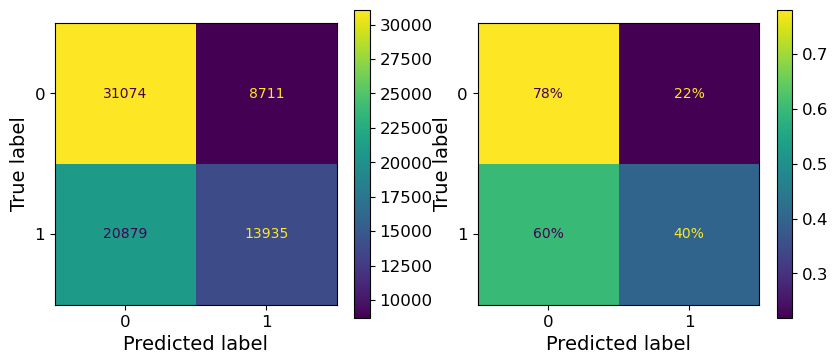

In [98]:
# Confusion matrix
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_train, sgd_preds, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_train, sgd_preds, normalize='true', values_format='.0%', ax=axs[1])
plt.show()

In [99]:
sgd_accuracy = accuracy_score(y_train, sgd_preds)
sgd_recall = recall_score(y_train, sgd_preds)

print(f"Accuracy: {round(sgd_accuracy, 3)}")
print(f"Recall: {round(sgd_recall, 3)}")

Accuracy: 0.603
Recall: 0.4


## Logistic Regression

In [100]:
log_clf = LogisticRegression(solver='newton-cg', random_state=42, max_iter=1000)
cross_val_score(log_clf, X_train, y_train, cv=3)

array([0.62082278, 0.6238237 , 0.6134883 ])

In [101]:
log_preds = cross_val_predict(log_clf, X_train, y_train, cv=3)

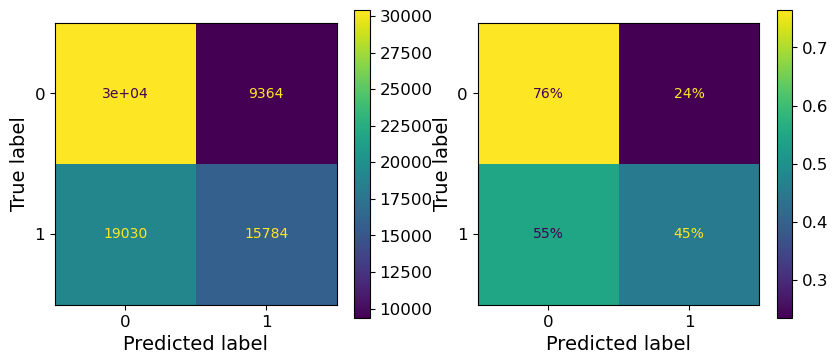

In [102]:
# Confusion matrix
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_train, log_preds, ax=axs[0])

ConfusionMatrixDisplay.from_predictions(y_train, log_preds, normalize='true', values_format='.0%', ax=axs[1])
plt.show()

In [103]:
log_accuracy = accuracy_score(y_train, log_preds)
log_recall = recall_score(y_train, log_preds)

print(f"Accuracy: {round(log_accuracy, 3)}")
print(f"Recall: {round(log_recall, 3)}")

Accuracy: 0.619
Recall: 0.453


## Random Forest

In [104]:
forest_clf = RandomForestClassifier(random_state=42)
cross_val_score(forest_clf, X_train, y_train, cv=3)

array([0.61611775, 0.62462801, 0.61911848])

In [105]:
forest_preds = cross_val_predict(forest_clf, X_train, y_train, cv=3)

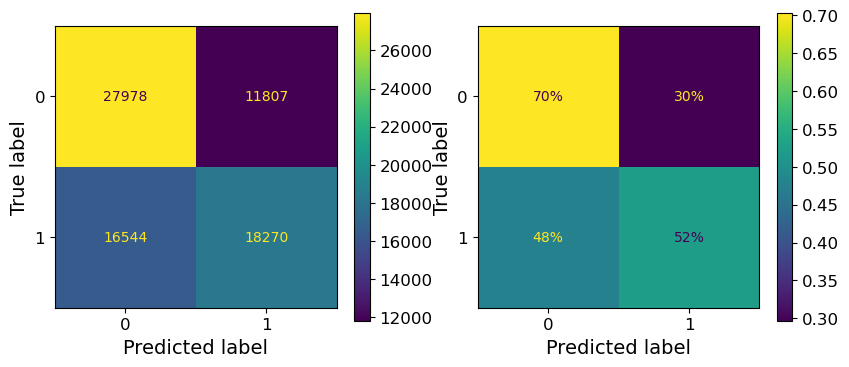

In [106]:
# Confusion matrix
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_train, forest_preds, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_train, forest_preds, normalize='true', values_format='.0%', ax=axs[1])
plt.show()

In [107]:
forest_accuracy = accuracy_score(y_train, forest_preds)
forest_recall = recall_score(y_train, forest_preds)

print(f"Accuracy: {round(forest_accuracy, 3)}")
print(f"Recall: {round(forest_recall, 3)}")

Accuracy: 0.62
Recall: 0.525


In [108]:
forest_clf.fit(X_train, y_train)
f_imp = forest_clf.feature_importances_

In [109]:
f_imp_df = pd.DataFrame(f_imp, index=X_train.columns.values, columns=['importance'])
f_imp_df['importance'] = f_imp_df['importance'].apply(lambda x: round(x, 3))
f_imp_df.sort_values('importance', ascending=False)[:25]

,importance
lab_procedures_and_medications,0.110
lab_procedure_hospital_time_ratio,0.104
num_medications_hospital_ratio,0.096
procedures_and_medications,0.068
time_in_hospital,0.055
visits_age_ratio,0.055
age,0.052
number_diagnoses,0.043
total_visits,0.038
drugs_steady_ratio,0.018


## K-Neighbors Classifier

In [110]:
knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, X_train, y_train, cv=3)

array([0.56315599, 0.55770932, 0.56474704])

In [111]:
knn_preds = cross_val_predict(knn_clf, X_train, y_train, cv=3)

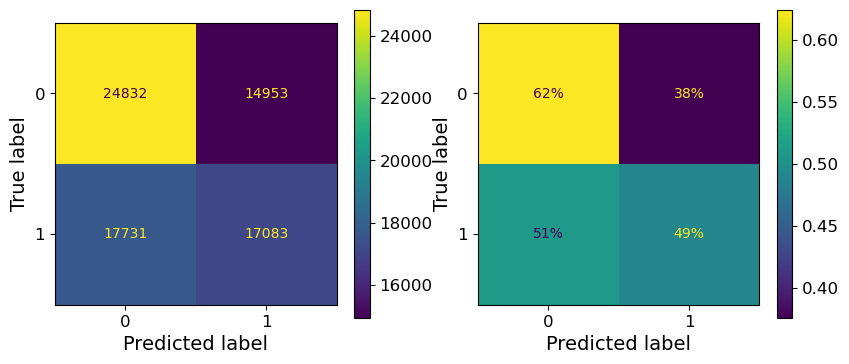

In [112]:
# Confusion matrix
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_train, knn_preds, ax=axs[0])

ConfusionMatrixDisplay.from_predictions(y_train, knn_preds, normalize='true', values_format='.0%', ax=axs[1])
plt.show()

In [113]:
knn_accuracy = accuracy_score(y_train, knn_preds)
knn_recall = recall_score(y_train, knn_preds)

print(f"Accuracy: {round(knn_accuracy, 3)}")
print(f"Recall: {round(knn_recall, 3)}")

Accuracy: 0.562
Recall: 0.491


## XGBoost Classifier

In [114]:
#Create an XGBoost classifier instance and set the parameters
xgb_model = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=100,
    min_child_weight=5,
    max_depth=5,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.6,
    eval_metric='logloss'
)

In [115]:
# Cross-validation and prediction
cross_val_score(xgb_model, X_train, y_train, cv=3)  

array([0.6292677 , 0.63431995, 0.63114293])

In [116]:
xgb_preds = cross_val_predict(xgb_model, X_train, y_train, cv=3)  

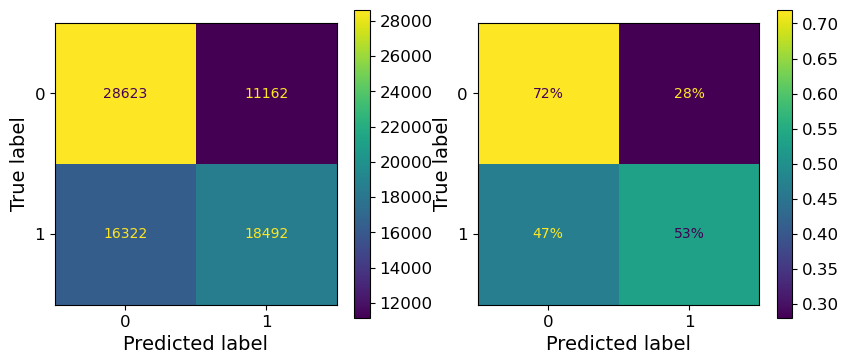

In [117]:
# Plot confusion matrix (absolute values and normalized)
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_train, xgb_preds, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_train, xgb_preds, normalize='true', values_format='.0%', ax=axs[1])
plt.show()

In [118]:
xgb_accuracy = accuracy_score(y_train, xgb_preds)
xgb_recall = recall_score(y_train, xgb_preds)

print(f"Accuracy: {round(xgb_accuracy, 3)}")
print(f"Recall: {round(xgb_recall, 3)}")

Accuracy: 0.632
Recall: 0.531


## Neural Network

In [119]:
#from sklearn.model_selection import KFold, cross_val_score, train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [120]:
model = Sequential()
model.add(Dense(142, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

/home/dinura/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727964667.887562     599 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727964668.021041     599 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727964668.021106     599 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727964668.027762     599 cuda_executor.cc:1001] co

In [121]:
history=model.fit(
    X_train,y_train,
    epochs=300, #can change the epoch
    validation_split=0.2, 
    verbose=1, 
    batch_size=256,
    callbacks=[early_stopping]
)

Epoch 1/300


/home/dinura/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1727964670.224593    1503 service.cc:146] XLA service 0x7fddbc004300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727964670.224638    1503 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-03 19:41:10.254323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 19:41:10.366892: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-03 19:41:11.706777: I external/local_xla/xla/stream_exe

112/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6967 - sparse_categorical_accuracy: 0.5140

I0000 00:00:1727964676.559606    1503 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.5259

2024-10-03 19:41:18.052899: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_443', 8 bytes spill stores, 8 bytes spill loads

2024-10-03 19:41:18.219286: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_439', 20 bytes spill stores, 20 bytes spill loads

2024-10-03 19:41:18.362364: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_439', 4 bytes spill stores, 4 bytes spill loads

2024-10-03 19:41:18.673274: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_441', 32 bytes spill stores, 32 bytes spill loads

2024-10-03 19:41:18.853544: I external/local_xla/xla/stream_executor

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5272

/home/dinura/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-10-03 19:41:23.403672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 16 bytes spill stores, 16 bytes spill loads

2024-10-03 19:41:24.318207: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 336 bytes spill stores, 248 bytes spill loads



234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5273 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.5773
Epoch 2/300
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.5776 - val_loss: 0.6676 - val_sparse_categorical_accuracy: 0.5955
Epoch 3/300
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.5985 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.6041
Epoch 4/300
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.6100 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6092
Epoch 5/300
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6560 - sparse_categorical_accuracy: 0.6132 - val_loss: 0.6580 - val_sparse_categorical_accuracy: 0.6114
Epoch 6/300
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6165 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.6142
Epoch 7/

In [122]:
y_pred = model.predict(X_train)
y_pred

2308/2332 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step

2024-10-03 19:41:50.139267: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 8 bytes spill stores, 8 bytes spill loads



2332/2332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


array([[0.38174888, 0.564554  ],
       [0.5227632 , 0.37536013],
       [0.67894053, 0.30069947],
       ...,
       [0.5979558 , 0.36038482],
       [0.41964677, 0.48181027],
       [0.35462633, 0.56143755]], dtype=float32)

In [123]:
lst=[]

for i in range(0,len(y_pred)):
     k=np.argmax(y_pred[i]) #it gives index value of the highest probability for each iteration 
     lst.append(k)

nn_preds=np.array(lst)

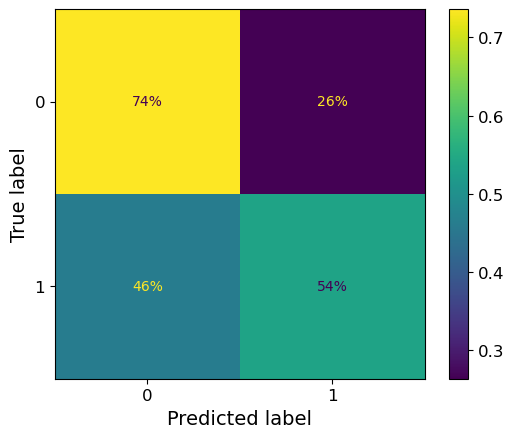

In [124]:
ConfusionMatrixDisplay.from_predictions(y_train, nn_preds, normalize='true', values_format='.0%')
plt.grid(visible=False)
plt.show()

In [125]:
nn_accuracy = accuracy_score(y_train, nn_preds)
nn_recall = recall_score(y_train, nn_preds)

print(f"Accuracy: {round(nn_accuracy, 3)}")
print(f"Recall: {round(nn_recall, 3)}")

Accuracy: 0.643
Recall: 0.538


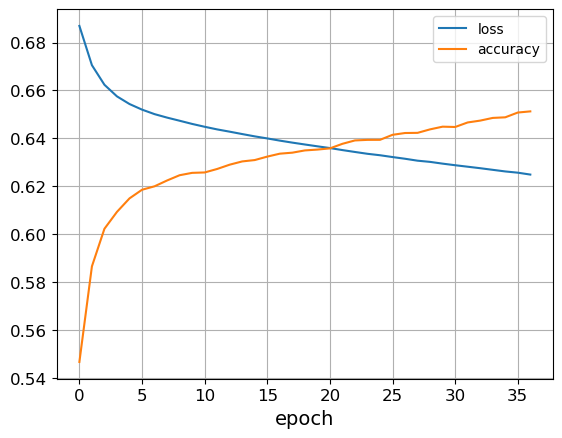

In [126]:
loss=history.history['loss']
accuracy = history.history['sparse_categorical_accuracy']
epoch = history.epoch

def plot(loss, accuracy, epoch):
    axis=list(range(0, len(loss),1))
    fig, ax = plt.subplots()
    ax.plot(epoch, loss, label='loss')
    ax.plot(epoch, accuracy, label='accuracy')
    ax.set_xlabel('epoch')
    plt.legend()
    ax.grid()
    plt.show()
    
plot(loss, accuracy, epoch)

## Tested Models Summary

In [127]:
models_tested = {
    'Accuracy': [sgd_accuracy, log_accuracy, forest_accuracy, knn_accuracy, xgb_accuracy, nn_accuracy],
    'Recall': [sgd_recall, log_recall, forest_recall, knn_recall, xgb_recall, nn_recall]
}

tested_model_df = pd.DataFrame(models_tested, index=['SGD', 'Logistic', 'Random Forest', 'K-Neighbors', 'XGBoost', 'Neural Network'])
tested_model_df[['Accuracy', 'Recall']] = tested_model_df[['Accuracy', 'Recall']].apply(lambda x: round(x, 3))
tested_model_df.sort_values('Accuracy', ascending=False)

,Accuracy,Recall
Neural Network,0.643,0.538
XGBoost,0.632,0.531
Random Forest,0.620,0.525
Logistic,0.619,0.453
SGD,0.603,0.400
K-Neighbors,0.562,0.491


__Insight__
<br>
Neural Network and XGBoost models have the highest accuracies and recalls.

# Hyperparameter Tuning

Since Neural Network and XGBoost models have the best performance among the tested models, tune hyperparameters for those.

## Neural Network

We'll user Keras Tuner to tune the hyperparameters for the neural network.

In [129]:
def model_builder(hp):
    model = Sequential()
    
    hp_activation = hp.Choice('activation', values=['sigmoid', 'tanh', 'softmax', 'relu'])
    hp_layer_1 = hp.Int('layer_1', min_value=0, max_value=1000, step=4)
    hp_layer_2 = hp.Int('layer_2', min_value=0, max_value=1000, step=4)
    hp_layer_3 = hp.Int('layer_3', min_value=0, max_value=1000, step=4)
    hp_layer_4 = hp.Int('layer_4', min_value=0, max_value=1000, step=4)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])

    model.add(Dense(units=hp_layer_1, input_dim=X_train.shape[1], activation=hp_activation))
    model.add(Dense(units=hp_layer_2, activation=hp_activation))
    model.add(Dense(units=hp_layer_3, activation=hp_activation))
    model.add(Dense(units=hp_layer_4, activation=hp_activation))
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return model

In [130]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [131]:
k_tuner = kt.Hyperband(model_builder, objective='val_sparse_categorical_accuracy', max_epochs=10, factor=3)

Reloading Tuner from ./untitled_project/tuner0.json


In [132]:
k_tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

In [133]:
best_h_params = k_tuner.get_best_hyperparameters(num_trials=1)[0]
best_h_params.values

{'activation': 'relu',
 'layer_1': 596,
 'layer_2': 648,
 'layer_3': 540,
 'layer_4': 52,
 'learning_rate': 1e-05,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [134]:
nn_model = k_tuner.hypermodel.build(best_h_params)
nn_history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/home/dinura/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-03 19:42:21.323417: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_439', 20 bytes spill stores, 20 bytes spill loads

2024-10-03 19:42:21.332800: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_441', 32 bytes spill stores, 32 bytes spill loads

2024-10-03 19:42:21.352648: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_439', 

1843/1865 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.6450

2024-10-03 19:42:28.531925: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 8 bytes spill stores, 8 bytes spill loads



1865/1865 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.6518 - val_sparse_categorical_accuracy: 0.6187
Epoch 2/50
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6264 - sparse_categorical_accuracy: 0.6464 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6203
Epoch 3/50
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.6513 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.6237
Epoch 4/50
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.6210
Epoch 5/50
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6211 - sparse_categorical_accuracy: 0.6536 - val_loss: 0.6498 - val_sparse_categorical_accuracy: 0.6241
Epoch 6/50
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6216 - sparse_categorical_accuracy: 0.6542 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6202
Epo

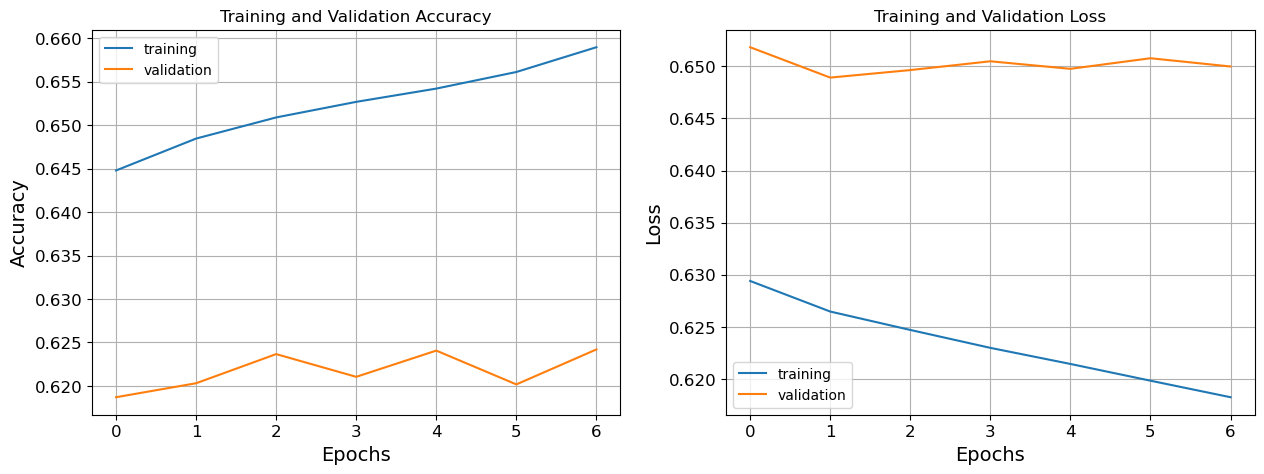

In [135]:
# Plot tuned model's accuracy and loss
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(nn_history.epoch, nn_history.history['sparse_categorical_accuracy'], label='training')
plt.plot(nn_history.epoch, nn_history.history['val_sparse_categorical_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(122)
plt.plot(nn_history.epoch, nn_history.history['loss'], label='training')
plt.plot(nn_history.epoch, nn_history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Training and Validation Loss')

plt.show()

In [136]:
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 596)            │        47,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 648)            │       386,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 540)            │       350,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 52)             │        28,132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           106 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,638 (3.10 MB)

 Trainable params: 812,638 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
nn_tuned_preds = nn_model.predict(X_train)

2024-10-03 19:42:53.303387: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 248 bytes spill stores, 248 bytes spill loads

2024-10-03 19:42:53.303579: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 240 bytes spill stores, 240 bytes spill loads

2024-10-03 19:42:53.422402: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 32 bytes spill stores, 32 bytes spill loads

2024-10-03 19:42:53.580248: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 228 bytes spill stores, 228 bytes spill loads



2332/2332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [138]:
print(classification_report(y_train, nn_tuned_preds.argmax(axis=1), target_names=['Readmit-No', 'Readmit-Yes']))

              precision    recall  f1-score   support

  Readmit-No       0.54      0.34      0.42     39785
 Readmit-Yes       0.47      0.66      0.55     34814

    accuracy                           0.49     74599
   macro avg       0.50      0.50      0.48     74599
weighted avg       0.51      0.49      0.48     74599



In [139]:
tuned_lst=[]

for i in range(0,len(nn_tuned_preds)):
     k=np.argmax(nn_tuned_preds[i]) #it gives index value of the highest probability for each iteration 
     tuned_lst.append(k)

nn_tuned_preds=np.array(lst)

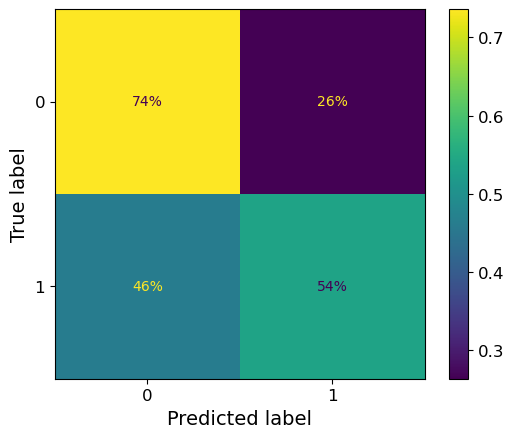

In [140]:
ConfusionMatrixDisplay.from_predictions(y_train, nn_tuned_preds, normalize='true', values_format='.0%')
plt.grid(visible=False)

In [141]:
nn_tuned_accuracy = accuracy_score(y_train, nn_tuned_preds)
nn_tuned_recall = recall_score(y_train, nn_tuned_preds)

print(f"Accuracy: {round(nn_tuned_accuracy, 3)}")
print(f"Recall: {round(nn_tuned_recall, 3)}")

Accuracy: 0.643
Recall: 0.538


__Insight__
<br>
There doesn't seem to be any imporvement of the accuracy or recall of the neural network even after tuning the hyper-parameters.

## XGBoost

In [703]:
# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

In [704]:
# Define the hyperparameters want to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [705]:
# Create the GridSearchCV object
xgb_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# Fit the model
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\LEGION\anaconda3\envs\py3-tf2\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LEGION\anaconda3\envs\py3-tf2\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LEGION\anaconda3\envs\py3-tf2\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\LEGION\anaconda3\envs\py3-tf2\Lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, eva

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [706]:
xgb_search.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'subsample': 0.7}

In [707]:
# Evaluate the best model on the test set
xgb_model = xgb_search.best_estimator_

In [708]:
xgb_tuned_preds = xgb_model.predict(X_train)

In [709]:
print(classification_report(y_train, xgb_tuned_preds, target_names=['Readmit-No', 'Readmit-Yes']))

              precision    recall  f1-score   support

  Readmit-No       0.67      0.75      0.71     39785
 Readmit-Yes       0.67      0.57      0.61     34814

    accuracy                           0.67     74599
   macro avg       0.67      0.66      0.66     74599
weighted avg       0.67      0.67      0.66     74599



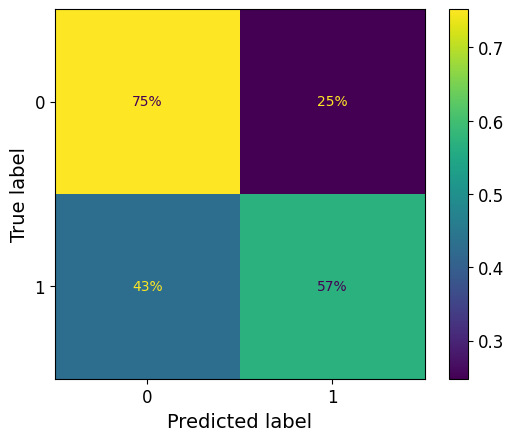

In [710]:
ConfusionMatrixDisplay.from_predictions(y_train, xgb_tuned_preds, normalize='true', values_format='.0%')
plt.grid(visible=False)
plt.show()

In [711]:
xgb_tuned_accuracy = accuracy_score(y_train, xgb_tuned_preds)
xgb_tuned_recall = recall_score(y_train, xgb_tuned_preds)

print(f"Accuracy: {round(xgb_tuned_accuracy, 3)}")
print(f"Recall: {round(xgb_tuned_recall, 3)}")

Accuracy: 0.667
Recall: 0.569


__IMPORTANT__
<br>
Between hyperparameter-tuned Neural Network model and the XGBoost model, the XGBoost model has a higher accuracy and recall scores. Therefore we will use this model as the finalized model.

# Testing

Test the finalized model performance.

In [715]:
y_test_preds = xgb_model.predict(X_test)

print(classification_report(y_test, y_test_preds, target_names=['Readmit-No', 'Readmit-Yes']))

              precision    recall  f1-score   support

  Readmit-No       0.65      0.73      0.69     10091
 Readmit-Yes       0.62      0.53      0.58      8559

    accuracy                           0.64     18650
   macro avg       0.64      0.63      0.63     18650
weighted avg       0.64      0.64      0.64     18650



In [716]:
print(f"Testing Accuracy: {round(accuracy_score(y_test, y_test_preds), 3)}")
print(f"Testing Recall: {round(recall_score(y_test, y_test_preds), 3)}")

Testing Accuracy: 0.639
Testing Recall: 0.535
